In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine
import scipy.sparse
import tqdm
import xswap

warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
# Generate a random graph with a given density
def random_graph_adjacency(density, num_source=1000, num_target=1000, seed=0):
    np.random.seed(seed)
    base = np.random.rand(num_source * num_target)
    flat_graph = base < density
    graph = flat_graph.reshape(num_source, num_target).astype(int)
    return graph

def random_graph_edges(density, num_source=1000, num_target=1000, seed=0):
    random_adj = random_graph_adjacency(density, num_source, num_target, seed)
    sp_adj = scipy.sparse.coo_matrix(random_adj)
    edges = list(zip(sp_adj.row, sp_adj.col))
    edges, _, _ = xswap.preprocessing.map_str_edges(edges, bipartite=(num_source==num_target))
    return edges

In [3]:
densities = (1e-3, 0.1, 0.25, 0.5, 0.7, 0.9)
multipliers = np.linspace(0, 10)

density_multiplier_to_stats = dict()
swap_percent_list = list()

for density in tqdm.tqdm(densities):
    edge_list = random_graph_edges(density, 1000, 1000)
    original_edges = set(edge_list)

    for multiplier in multipliers:
        edge_list, density_multiplier_to_stats[(density, multiplier)] = xswap.permute_edge_list(
            edge_list, allow_self_loops=True, allow_antiparallel=False, multiplier=multiplier, seed=0)
        perm_edges = set(
            [edge for edge in edge_list if edge[0] <= edge[1]]
            + [(edge[1], edge[0]) for edge in edge_list if edge[0] > edge[1]]
        )
        percent_changed = 1 - len(original_edges.intersection(perm_edges)) / len(original_edges)
        swap_percent_list.append([density, multiplier, percent_changed])

100%|██████████| 6/6 [03:59<00:00, 39.90s/it]


In [4]:
swap_percent_array = np.array(swap_percent_list)
swap_percent_df = pd.DataFrame(swap_percent_array, columns=['density', 'multiplier', 'percent_changed'])

swap_percent_df.head()

,density,multiplier,percent_changed
0,0.001,0.000000,0.000000
1,0.001,0.204082,0.323253
2,0.001,0.408163,0.431700
3,0.001,0.612245,0.582899
4,0.001,0.816327,0.701773


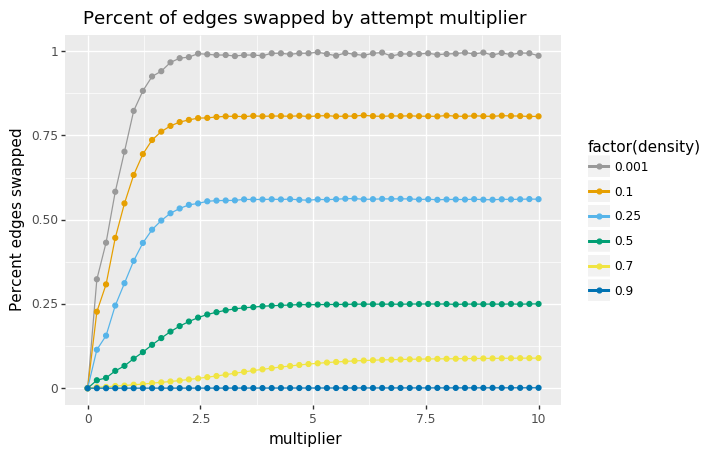

<ggplot: (8784371771340)>

In [5]:
g = (
    plotnine.ggplot()
    + plotnine.geom_line(data=swap_percent_df, 
                         mapping=plotnine.aes(x='multiplier', y='percent_changed', color='factor(density)'))
    + plotnine.geom_point(data=swap_percent_df, 
                         mapping=plotnine.aes(x='multiplier', y='percent_changed', color='factor(density)'))
    + plotnine.labels.ggtitle('Percent of edges swapped by attempt multiplier')
    + plotnine.labels.ylab('Percent edges swapped')
    + plotnine.scale_color_manual(values=[
        "#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"
    ])
)
g.save(filename='../outputs/swap_percent/by_multiplier.png', format='png')
g

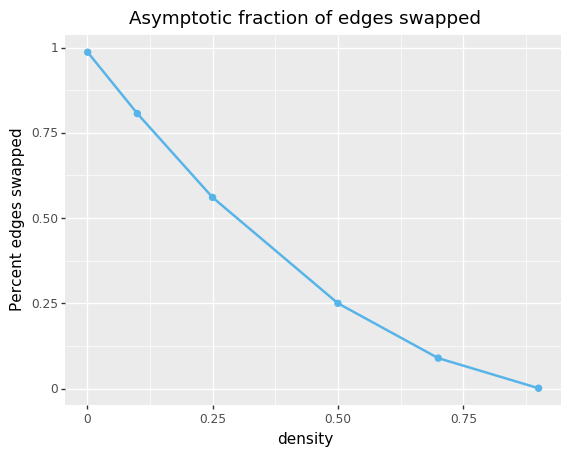

<ggplot: (-9223363252493630327)>

In [6]:
plateau_percents = (
    swap_percent_df
    .query('multiplier == 10')
)

g = (
    plotnine.ggplot()
    + plotnine.geom_line(data=plateau_percents, 
                         mapping=plotnine.aes(x='density', y='percent_changed'),
                         color='#56B4E9', size=1
    )
    + plotnine.geom_point(data=plateau_percents, 
                         mapping=plotnine.aes(x='density', y='percent_changed'),
                         color='#56B4E9', size=2
    )
    + plotnine.labels.ggtitle('Asymptotic fraction of edges swapped')
    + plotnine.labels.ylab('Percent edges swapped')
)
g.save(filename='../outputs/swap_percent/by_density.png', format='png')
g